### Data Collection for Tesla's Stock Data

In [1]:
# importing libraries
import yfinance as yf
import pandas as pd
import numpy as np

# EDA Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelling
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler



In [2]:
# download TSLA data
tsla = yf.download("TSLA", start="2010-06-29", end="2025-11-21", interval="1d")

# Inspect
print(tsla.head())

C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\1322452272.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download("TSLA", start="2010-06-29", end="2025-11-21", interval="1d")
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          TSLA      TSLA      TSLA      TSLA       TSLA
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [3]:
# Save to csv
tsla.to_csv("tsla_stock_data.csv") 

In [4]:
# Check what your columns look like
print(tsla.columns)
print(tsla.head())

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])
Price          Close      High       Low      Open     Volume
Ticker          TSLA      TSLA      TSLA      TSLA       TSLA
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [5]:
# Let's recalculate for the adjusted close

# creating the adj_close column
tsla['Adj_Close'] = tsla['Close'].copy()

# Define split dates and ratios
splits = [
    ('2022-08-25', 3),  # 3-for-1 split
    ('2020-08-31', 5),  # 5-for-1 split
]

# Adjust prices before each split
for split_date, split_ratio in splits:
    # All prices BEFORE the split date need to be divided by the split ratio
    mask = tsla.index < split_date
    tsla.loc[mask, 'Adj_Close'] = tsla.loc[mask, 'Adj_Close'] / split_ratio

# Verify the adjustment
print("Original Close vs Adjusted Close:")
print(tsla[['Close', 'Adj_Close']].head())
print("\n")
print(tsla[['Close', 'Adj_Close']].tail())

Original Close vs Adjusted Close:
Price          Close Adj_Close
Ticker          TSLA          
Date                          
2010-06-29  1.592667  0.106178
2010-06-30  1.588667  0.105911
2010-07-01  1.464000  0.097600
2010-07-02  1.280000  0.085333
2010-07-06  1.074000  0.071600


Price            Close   Adj_Close
Ticker            TSLA            
Date                              
2025-11-14  404.350006  404.350006
2025-11-17  408.920013  408.920013
2025-11-18  401.250000  401.250000
2025-11-19  403.989990  403.989990
2025-11-20  395.230011  395.230011


The adjusted close (adj_close) is quite necessary for stock analysis since it accounts for stock splits and dividends. In relation to Tesla this is quite necessary since the company_ has had 5 several stock splits, 5-for-1 in 2020 and 3-for-1 in 2022 and as a result, working without accounting for the same will lead to misleading historical data. The result of having and adjusted close is that it gives a continuous split-adjusted price series that is perfect for time series analysis and forecasting which will happen towards the end of the project.

In [6]:
# Flatten MultiIndex columns if they exist
if isinstance(tsla.columns, pd.MultiIndex):
    tsla.columns = tsla.columns.get_level_values(0)

# Date should already be the index from yfinance, but verify
if 'Date' in tsla.columns:
    tsla = tsla.set_index('Date')

# Now resample
tsla_weekly = tsla['Adj_Close'].resample('W').last()
tsla_monthly = tsla['Adj_Close'].resample('M').last()

print(tsla_weekly.head())
print(tsla_monthly.head())

Date
2010-07-04    0.085333
2010-07-11    0.077333
2010-07-18    0.091733
2010-07-25    0.094622
2010-08-01    0.088622
Freq: W-SUN, Name: Adj_Close, dtype: float64
Date
2010-06-30    0.105911
2010-07-31    0.088622
2010-08-31    0.086578
2010-09-30    0.090711
2010-10-31    0.097067
Freq: ME, Name: Adj_Close, dtype: float64


C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\423368309.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tsla_monthly = tsla['Adj_Close'].resample('M').last()


In [7]:
tsla.shape

(3875, 6)

### Elon Musk's Net Worth Data

Now, concerning Musk's historical data, I will manually collect historical net worth data from a range of sources then save the same to a csv. 

In [8]:
# Create historical Elon Musk net worth data manually
# Sources: Forbes, Bloomberg Billionaires Index

elon_networth = pd.DataFrame({
    'Date': pd.to_datetime([
        '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
        '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31',
        '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31',
        '2022-12-31', '2023-12-31', '2024-12-31', '2025-11-21'
    ]),
    'Net_Worth_Billions': [
        2.4,    # 2010
        2.0,    # 2011
        2.4,    # 2012
        9.0,    # 2013
        10.7,   # 2014
        12.1,   # 2015
        11.6,   # 2016
        20.0,   # 2017
        23.6,   # 2018
        22.3,   # 2019
        167.0,  # 2020 (massive Tesla stock surge)
        273.5,  # 2021 (peak at $300B+)
        147.0,  # 2022 (Twitter acquisition, Tesla decline)
        232.0,  # 2023
        400.0,  # 2024 Dec (first person to $400B)
        500.0   # 2025 Nov (first person to $500B)
    ]
})

elon_networth.set_index('Date', inplace=True)
elon_networth.to_csv("elon_networth.csv")

print("Elon Musk's Net Worth Over Time:")
print(elon_networth)
print(f"\nLatest Net Worth: ${elon_networth['Net_Worth_Billions'].iloc[-1]} Billion")

# Calculate growth rate
initial = elon_networth['Net_Worth_Billions'].iloc[0]
final = elon_networth['Net_Worth_Billions'].iloc[-1]
years = (elon_networth.index[-1] - elon_networth.index[0]).days / 365.25
cagr = ((final / initial) ** (1/years) - 1) * 100

print(f"\nCompound Annual Growth Rate (2010-2025): {cagr:.2f}%")

Elon Musk's Net Worth Over Time:
            Net_Worth_Billions
Date                          
2010-12-31                 2.4
2011-12-31                 2.0
2012-12-31                 2.4
2013-12-31                 9.0
2014-12-31                10.7
2015-12-31                12.1
2016-12-31                11.6
2017-12-31                20.0
2018-12-31                23.6
2019-12-31                22.3
2020-12-31               167.0
2021-12-31               273.5
2022-12-31               147.0
2023-12-31               232.0
2024-12-31               400.0
2025-11-21               500.0

Latest Net Worth: $500.0 Billion

Compound Annual Growth Rate (2010-2025): 43.12%


In [9]:
elon_networth.shape

(16, 1)

### Assessing Elon Musk's ownershup percentage over time and how it has continued to change 

In [11]:
# Elon Musk's Tesla Ownership Percentage Over Time
# Sources: SEC filings, proxy statements, financial news
elon_ownership_stake = pd.DataFrame({
    'Date': pd.to_datetime([
        '2010-06-29',  # IPO date
        '2012-12-31',
        '2015-12-31',
        '2018-12-31',
        '2020-12-31',
        '2021-12-31',
        '2022-12-31',  # After Twitter purchase stock sales
        '2023-12-31',
        '2024-12-31',
        '2025-11-21'   # Current
    ]),
    'Ownership_Percentage': [
        29.0,   # After IPO
        28.0,   # Slight dilution
        22.0,   # More dilution from capital raises
        21.5,   # Continued dilution
        20.8,   # 2020
        21.2,   # After exercising stock options
        17.0,   # Dropped after selling ~$23B for Twitter
        13.0,   # Stabilized post-Twitter
        12.9,   # 2024
        12.8    # Current November 2025
    ],
    'Notes': [
        'IPO - diluted from 36% pre-IPO',
        'Minor dilution',
        'Capital raises for Model 3',
        'Pre-option exercises',
        'Stock split year',
        'Exercised options',
        'Sold for Twitter acquisition',
        'Post-Twitter stable',
        'Slight decline',
        'Current holding ~411M shares'
    ]
})

elon_ownership_stake.set_index('Date', inplace=True)
elon_ownership_stake.to_csv("elon_ownership_stake.csv")
print("Elon Musk's Tesla Ownership History:")
print(elon_ownership_stake)
print(f"\n Current Ownership: {elon_ownership_stake['Ownership_Percentage'].iloc[-1]}%")
print(f" Peak Ownership: {elon_ownership_stake['Ownership_Percentage'].max()}% in {elon_ownership_stake['Ownership_Percentage'].idxmax().year}")
print(f" Decline since IPO: {elon_ownership_stake['Ownership_Percentage'].iloc[0] - elon_ownership_stake['Ownership_Percentage'].iloc[-1]:.1f} percentage points")

Elon Musk's Tesla Ownership History:
            Ownership_Percentage                           Notes
Date                                                            
2010-06-29                  29.0  IPO - diluted from 36% pre-IPO
2012-12-31                  28.0                  Minor dilution
2015-12-31                  22.0      Capital raises for Model 3
2018-12-31                  21.5            Pre-option exercises
2020-12-31                  20.8                Stock split year
2021-12-31                  21.2               Exercised options
2022-12-31                  17.0    Sold for Twitter acquisition
2023-12-31                  13.0             Post-Twitter stable
2024-12-31                  12.9                  Slight decline
2025-11-21                  12.8    Current holding ~411M shares

 Current Ownership: 12.8%
 Peak Ownership: 29.0% in 2010
 Decline since IPO: 16.2 percentage points


In [12]:
elon_ownership_stake.shape

(10, 2)

### Merging the three datasets
#### However, in merging the datasets, there are several foreseeable hurdles that need to be considered; 1) Tesla stock data is in a daily format 2) Net worth data is in the form of yearly/milestone data/format 3) Ownership data is set at irregular intervals and mainly driven by events. The best approach here would be to resample the datasets into a common frequency which in this case will be monthly intervals.

In [13]:
# monthly net worth also factor in forward filling to interpolate between the years and months.

elon_networth_monthly = elon_networth.resample('M').last()
elon_networth_monthly = elon_networth_monthly.ffill()  # Forward fill

C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\3310311117.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  elon_networth_monthly = elon_networth.resample('M').last()


In [14]:
# Monthly ownership (forward fill between events)
elon_ownership_monthly = elon_ownership_stake['Ownership_Percentage'].resample('M').last()
elon_ownership_monthly = elon_ownership_monthly.ffill()  # Forward fill

C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\4067658273.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  elon_ownership_monthly = elon_ownership_stake['Ownership_Percentage'].resample('M').last()


In [15]:
# Merging all three datasets into one umbrella dataframe

merged_data = pd.DataFrame({
    'TSLA_Adj_Close': tsla_monthly,
    'Net_Worth_Billions': elon_networth_monthly['Net_Worth_Billions'],
    'Ownership_Percentage': elon_ownership_monthly
})

In [16]:
# Check for missing data

merged_data.isna().sum()

TSLA_Adj_Close          0
Net_Worth_Billions      6
Ownership_Percentage    0
dtype: int64

In [17]:
# To see how many rows have AT LEAST ONE missing value:
total_rows_with_missing_data = merged_data.isnull().any(axis=1).sum()
print(total_rows_with_missing_data)

6


In [18]:
merged_data.shape

(186, 3)

#### considering the data, the best option here would be to backward fill the missing data on that single column. Backward filling will work here because we will invoke time series and the common assumption will be that his wealth was equal to or close to the first known value.

In [19]:
# 1. First, we ensure forward fill has been applied to handle internal gaps (which you already did)
merged_data['Net_Worth_Billions'] = merged_data['Net_Worth_Billions'].ffill()

# 2. Apply backward fill to handle NaN values at the start of the time series
merged_data['Net_Worth_Billions'] = merged_data['Net_Worth_Billions'].bfill()

# Check to confirm no more NaNs
print(merged_data['Net_Worth_Billions'].isnull().sum())

0


#### A lingering realization has continued to gnaw at me since the start of this project with the consideration that not all Musk's wealth is drawn from Tesla especially in recent years with his contributions at starlink, X (formerly twitter), neuralink, and SpaceX another major contributor to his wealth, also factoring to his wealth. Therefore, for the purpose of this project, we will have to calaculate the Total Shares Outstanding (TSO) and then calculate his historical TSLA wealth.

In [20]:
# Creating the TSO dataset (Approximate actual shares outstanding in Millions)
# Dates capture IPO, pre/post splits, and current period

tso_data = pd.DataFrame({
    'Date': pd.to_datetime([
        '2010-06-30',  # IPO approx
        '2020-08-28',  # Pre 5:1 Split (~186M actual shares)
        '2020-08-31',  # Post 5:1 Split (~932M actual shares)
        '2022-08-24',  # Pre 3:1 Split (Approx 1030M shares)
        '2022-08-25',  # Post 3:1 Split (~3090M shares)
        '2025-01-22',  # Latest filing (3,216.5M shares)
        '2025-11-30'   # End of data period
    ]),
    'TSLA_TSO_Millions': [120, 186.36, 931.8, 1030, 3090, 3216.5, 3330] 
})

tso_data.set_index('Date', inplace=True)

# Resampling and Forward Filling TSO to Monthly Frequency
tso_monthly = tso_data['TSLA_TSO_Millions'].resample('M').last().ffill()

# Merging the new TSO data into your existing merged_data
# We use .to_frame() to retain the column name
merged_data = merged_data.merge(
    tso_monthly.to_frame(),
    left_index=True,
    right_index=True,
    how='left'
)

C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\2589864737.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tso_monthly = tso_data['TSLA_TSO_Millions'].resample('M').last().ffill()


#### Recalculating TSLA wealth using code

In [21]:
# 1. Calculate Absolute Shares owned (optional, but useful for checking)
merged_data['Musk_Shares_Millions'] = (
    merged_data['TSLA_TSO_Millions'] * (merged_data['Ownership_Percentage'] / 100)
)

# 2. Calculate TSLA Wealth in Billions (The core calculation)
# TSO_Millions * Price / 1000 = Billions USD
merged_data['TSLA_Wealth_Billions'] = (
    merged_data['TSLA_Adj_Close'] * (merged_data['Ownership_Percentage'] / 100) * merged_data['TSLA_TSO_Millions'] / 1000
)

print("\n--- Merged Data Head (with new wealth columns) ---")
print(merged_data[['TSLA_Adj_Close', 'Ownership_Percentage', 'TSLA_TSO_Millions', 'TSLA_Wealth_Billions']].head())

print("\n--- Merged Data Tail (showing recent values) ---")
print(merged_data[['TSLA_Adj_Close', 'Ownership_Percentage', 'TSLA_TSO_Millions', 'TSLA_Wealth_Billions']].tail())

print(f"\nThe final merged dataset now has {merged_data.shape[0]} rows and {merged_data.shape[1]} columns.")


--- Merged Data Head (with new wealth columns) ---
            TSLA_Adj_Close  Ownership_Percentage  TSLA_TSO_Millions  \
Date                                                                  
2010-06-30        0.105911                  29.0              120.0   
2010-07-31        0.088622                  29.0              120.0   
2010-08-31        0.086578                  29.0              120.0   
2010-09-30        0.090711                  29.0              120.0   
2010-10-31        0.097067                  29.0              120.0   

            TSLA_Wealth_Billions  
Date                              
2010-06-30              0.003686  
2010-07-31              0.003084  
2010-08-31              0.003013  
2010-09-30              0.003157  
2010-10-31              0.003378  

--- Merged Data Tail (showing recent values) ---
            TSLA_Adj_Close  Ownership_Percentage  TSLA_TSO_Millions  \
Date                                                                  
2025-07-31   

#### Time to create a tesla multiplier that determines the relationship between the value of Elons Tesla stake and his total net worth. The formula behind it is dividing his total net worth by his TSLA stake calue at each point in time. An unintended result (but well appreciated) of this will be that it will also inform us of the non-TSLA assets were worth is relative to his TSLA stake.

In [22]:
# 1. CLEAN INPUTS FIRST: Backfill the Net Worth column
# This ensures we have a valid Net Worth value for the starting months (June-Nov 2010)
merged_data['Net_Worth_Billions'] = merged_data['Net_Worth_Billions'].bfill()

# 2. Calculate 'Other Wealth' (Net Worth - TSLA Wealth)
# Since inputs are now full, this column will be 100% full (no NaNs)
merged_data['Other_Wealth_Billions'] = (
    merged_data['Net_Worth_Billions'] - merged_data['TSLA_Wealth_Billions']
)

# 3. Calculate 'TSLA Multiplier' (Net Worth / TSLA Wealth)
merged_data['TSLA_Multiplier'] = (
    merged_data['Net_Worth_Billions'] / merged_data['TSLA_Wealth_Billions']
)
# Clean extreme values
merged_data['TSLA_Multiplier'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Calculate Growth Rate of 'Other Wealth'
merged_data['Other_Wealth_Growth'] = merged_data['Other_Wealth_Billions'].pct_change()

# FIX THE FINAL NULL: Fill the first row's NaN (result of pct_change) with 0
merged_data['Other_Wealth_Growth'] = merged_data['Other_Wealth_Growth'].fillna(0)

# 5. Calculate the Average Annual Growth Rate for your projection
annual_growth_rate = merged_data['Other_Wealth_Growth'].mean() * 12

# --- Verification ---
print(f"Estimated Annual Growth Rate (Other Wealth): {annual_growth_rate:.2%}")
print("\n--- Check for Missing Values ---")
print(merged_data[['Net_Worth_Billions', 'Other_Wealth_Billions', 'Other_Wealth_Growth']].isnull().sum())

Estimated Annual Growth Rate (Other Wealth): 168.53%

--- Check for Missing Values ---
Net_Worth_Billions       0
Other_Wealth_Billions    0
Other_Wealth_Growth      0
dtype: int64


C:\Users\Owner\AppData\Local\Temp\ipykernel_20648\3462007897.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['TSLA_Multiplier'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [23]:
merged_data.columns

Index(['TSLA_Adj_Close', 'Net_Worth_Billions', 'Ownership_Percentage',
       'TSLA_TSO_Millions', 'Musk_Shares_Millions', 'TSLA_Wealth_Billions',
       'Other_Wealth_Billions', 'TSLA_Multiplier', 'Other_Wealth_Growth'],
      dtype='object')

In [24]:
merged_data.isna().sum()

TSLA_Adj_Close           0
Net_Worth_Billions       0
Ownership_Percentage     0
TSLA_TSO_Millions        0
Musk_Shares_Millions     0
TSLA_Wealth_Billions     0
Other_Wealth_Billions    0
TSLA_Multiplier          0
Other_Wealth_Growth      0
dtype: int64

Project Status: TSLA Stock & Wealth Projection Model
Current Phase: Data Engineering & Model Architecture CompleteNext Phase: Exploratory Data Analysis (EDA) & Forecasting
1. Data Collection & Integration (Completed)
We have successfully gathered and unified the three core datasets required for the project, spanning from Tesla's IPO (June 2010) to the present (November 2025).
- TSLA Stock Data: Sourced daily historical pricing, utilizing Adjusted Close prices to correctly account for the 2020 (5:1) and 2022 (3:1) stock splits.
- Elon Musk's Net Worth: Aggregated historical net worth data points from major financial indices.
- Ownership & Shares: Compiled a timeline of Musk's ownership percentage and integrated Total Shares Outstanding (TSO) to calculate his absolute shareholding over time.
2. Data Processing Strategy (Completed)
To solve the challenge of irregular data frequencies (daily stock prices vs. annual/irregular net worth updates), we implemented a robust preprocessing pipeline:
- Resampling: Standardized all data to a monthly frequency.
- Imputation: Applied Forward Fill (ffill) to handle gaps between reporting periods and Backward Fill (bfill) to ensure the dataset is complete from the very first month of the analysis (June 2010).
- Merging: Successfully merged all datasets into a single, clean master DataFrame (merged_data) with 186 rows of continuous monthly data.
3. Wealth Modeling Architecture (Defined & Calculated)
Instead of a simple linear projection, we established a more sophisticated Two-Component Model to forecast future wealth:
- Component A (TSLA Wealth): We calculated the exact historical value of his Tesla stake (Stock Price $\times$ Shares Owned). This portion will be projected using our stock market forecast.
- Component B (Other Wealth): We isolated the value of his private assets (SpaceX, xAI, etc.) by calculating the residual (Total Net Worth - TSLA Wealth).
- Growth Metric: We calculated the Annual Growth Rate of the "Other Wealth" component, providing a stable historical baseline to project the non-Tesla portion of his fortune.
Summary of "Ready-to-Use" Data
We now have a clean dataset containing:
- TSLA_Adj_Close (The driver for the stock model)
- TSLA_Wealth_Billions (The public equity wealth)
- Other_Wealth_Billions (The private equity wealth)
- Other_Wealth_Growth (The rate for projecting private assets)

# Exploratory Data Analysis (EDA)

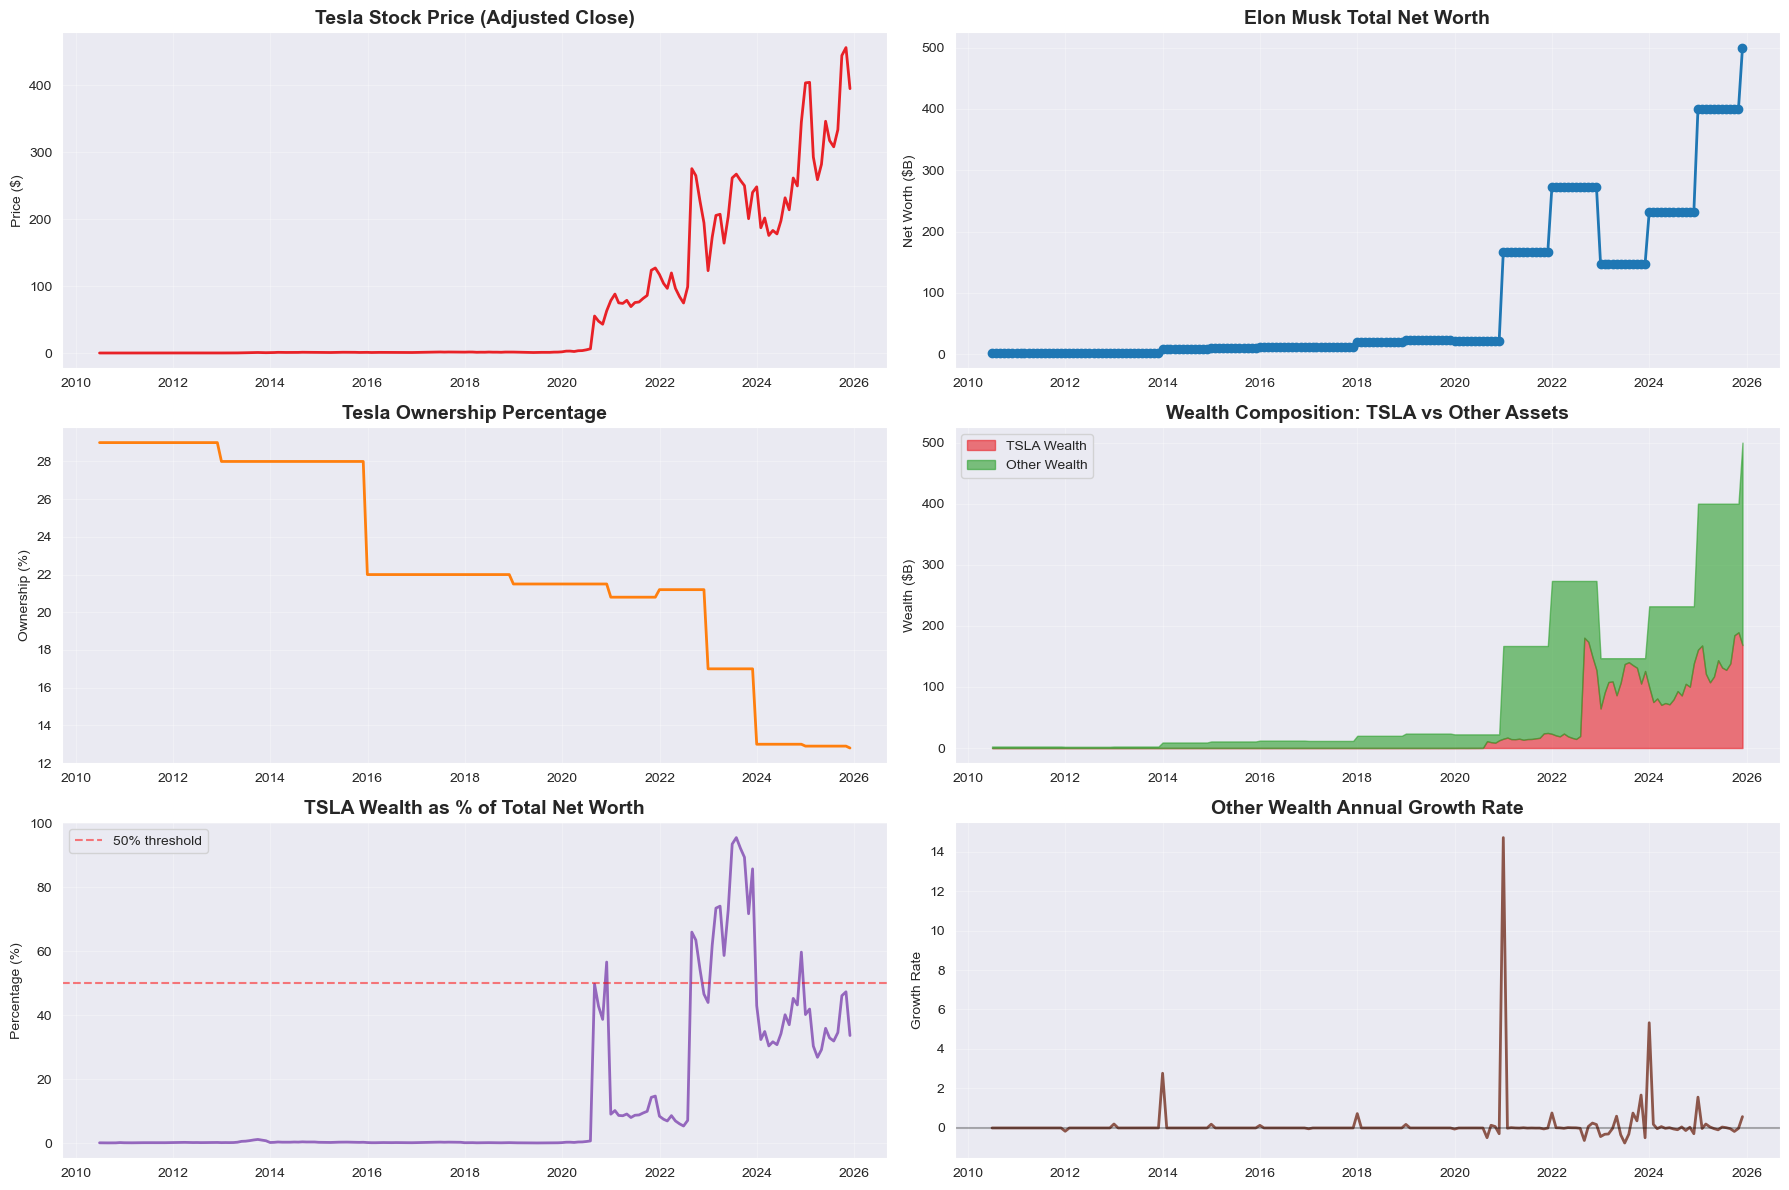

✅ EDA visualizations saved!


In [27]:

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 1. TIME SERIES VISUALIZATION
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# Plot 1: TSLA Stock Price Over Time
axes[0, 0].plot(merged_data.index, merged_data['TSLA_Adj_Close'], color='#E82127', linewidth=2)
axes[0, 0].set_title('Tesla Stock Price (Adjusted Close)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Total Net Worth Over Time
axes[0, 1].plot(merged_data.index, merged_data['Net_Worth_Billions'], color='#1f77b4', linewidth=2, marker='o')
axes[0, 1].set_title('Elon Musk Total Net Worth', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Net Worth ($B)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Ownership Percentage Over Time
axes[1, 0].plot(merged_data.index, merged_data['Ownership_Percentage'], color='#ff7f0e', linewidth=2)
axes[1, 0].set_title('Tesla Ownership Percentage', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Ownership (%)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: TSLA vs Other Wealth Components
axes[1, 1].fill_between(merged_data.index, 0, merged_data['TSLA_Wealth_Billions'], 
                         alpha=0.6, color='#E82127', label='TSLA Wealth')
axes[1, 1].fill_between(merged_data.index, merged_data['TSLA_Wealth_Billions'], 
                         merged_data['Net_Worth_Billions'], 
                         alpha=0.6, color='#2ca02c', label='Other Wealth')
axes[1, 1].set_title('Wealth Composition: TSLA vs Other Assets', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Wealth ($B)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: TSLA Wealth as % of Total
tsla_percentage = (merged_data['TSLA_Wealth_Billions'] / merged_data['Net_Worth_Billions'] * 100)
axes[2, 0].plot(merged_data.index, tsla_percentage, color='#9467bd', linewidth=2)
axes[2, 0].set_title('TSLA Wealth as % of Total Net Worth', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Percentage (%)')
axes[2, 0].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Other Wealth Growth Rate
axes[2, 1].plot(merged_data.index, merged_data['Other_Wealth_Growth'], color='#8c564b', linewidth=2)
axes[2, 1].set_title('Other Wealth Annual Growth Rate', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Growth Rate')
axes[2, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elon_wealth_eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ EDA visualizations saved!")

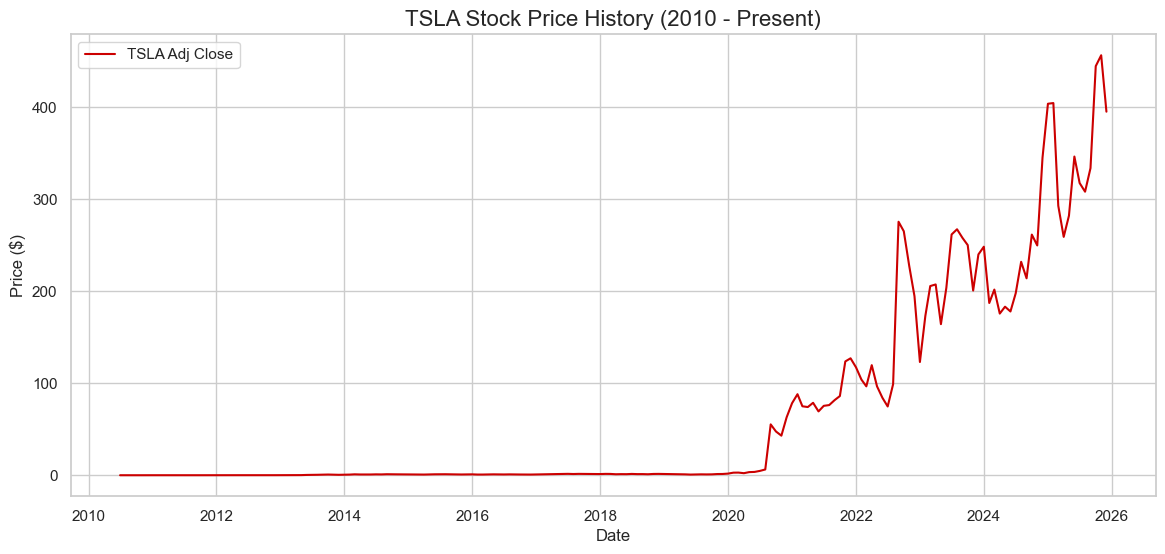

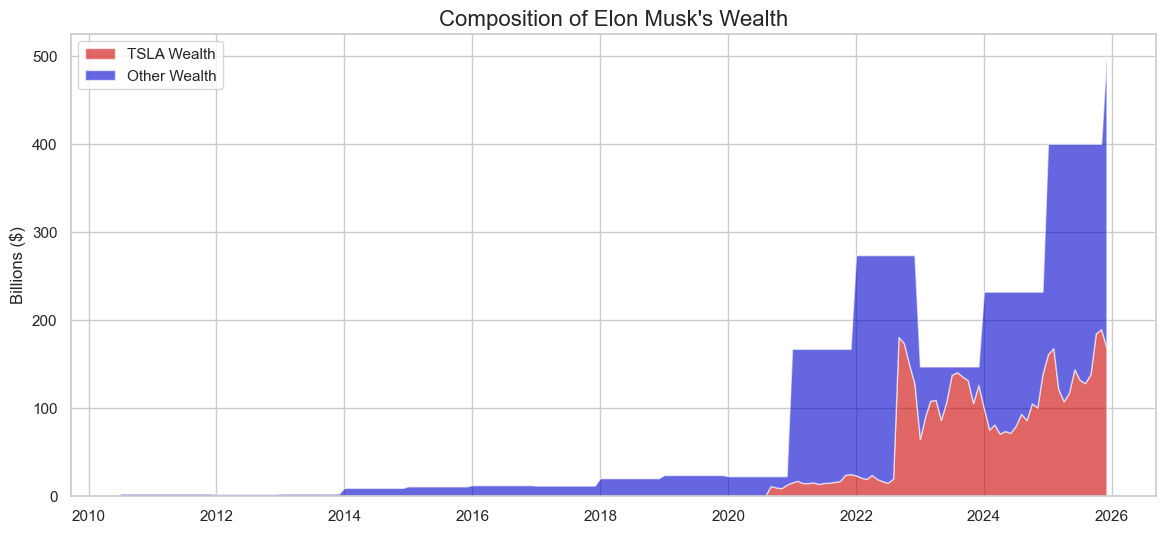

--- Augmented Dickey-Fuller Test (Stationarity Check) ---
ADF Statistic: 2.9146
p-value: 1.0000

Interpretation: The p-value is > 0.05. The data is NOT stationary.
Action Required: We will need to apply 'differencing' (d) in our ARIMA model.


In [28]:
# Set style for professional charting
sns.set(style='whitegrid')

# 1. Visualize the Primary Asset: TSLA Stock Price History
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index, merged_data['TSLA_Adj_Close'], label='TSLA Adj Close', color='#cc0000')
plt.title('TSLA Stock Price History (2010 - Present)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 2. Visualize the Secondary Layer: Wealth Components
plt.figure(figsize=(14, 6))
plt.stackplot(merged_data.index, 
              merged_data['TSLA_Wealth_Billions'], 
              merged_data['Other_Wealth_Billions'], 
              labels=['TSLA Wealth', 'Other Wealth'],
              colors=['#cc0000', '#0000cc'], alpha=0.6)
plt.title('Composition of Elon Musk\'s Wealth', fontsize=16)
plt.ylabel('Billions ($)')
plt.legend(loc='upper left')
plt.show()

# 3. Statistical Test: Augmented Dickey-Fuller (ADF) Test
# This tests if the stock data is "Stationary" (ready for ARIMA modeling)
print("--- Augmented Dickey-Fuller Test (Stationarity Check) ---")
result = adfuller(merged_data['TSLA_Adj_Close'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] > 0.05:
    print("\nInterpretation: The p-value is > 0.05. The data is NOT stationary.")
    print("Action Required: We will need to apply 'differencing' (d) in our ARIMA model.")
else:
    print("\nInterpretation: The p-value is <= 0.05. The data IS stationary.")

Stationarity Test Results Analysis
The Results:

ADF Statistic: 2.9146
p-value: 1.0000 (very high!)
Conclusion: NOT stationary ❌

What this means:
The TSLA stock price has a strong upward trend and the mean/variance changes over time. This is typical for stock prices and actually confirms your data is correct!

#### Statistical analysis and correlations

CORRELATION MATRIX


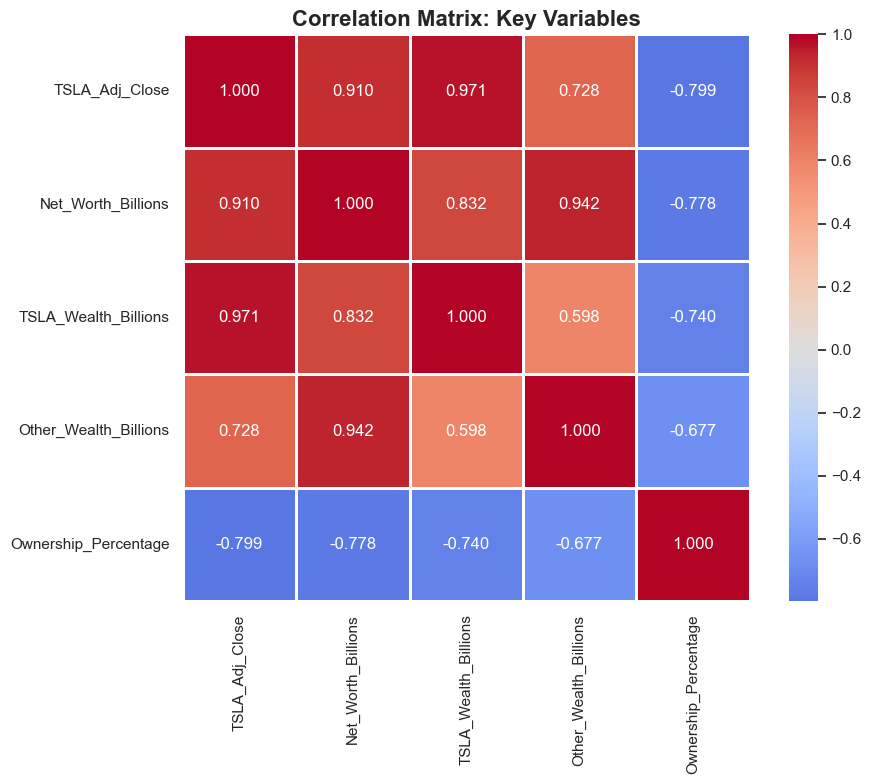

                       TSLA_Adj_Close  Net_Worth_Billions  \
TSLA_Adj_Close               1.000000            0.910283   
Net_Worth_Billions           0.910283            1.000000   
TSLA_Wealth_Billions         0.971342            0.832431   
Other_Wealth_Billions        0.728340            0.942110   
Ownership_Percentage        -0.798790           -0.778122   

                       TSLA_Wealth_Billions  Other_Wealth_Billions  \
TSLA_Adj_Close                     0.971342               0.728340   
Net_Worth_Billions                 0.832431               0.942110   
TSLA_Wealth_Billions               1.000000               0.598439   
Other_Wealth_Billions              0.598439               1.000000   
Ownership_Percentage              -0.740458              -0.676969   

                       Ownership_Percentage  
TSLA_Adj_Close                    -0.798790  
Net_Worth_Billions                -0.778122  
TSLA_Wealth_Billions              -0.740458  
Other_Wealth_Billions       

In [29]:
# CORRELATION ANALYSIS
print("=" * 60)
print("CORRELATION MATRIX")
print("=" * 60)

correlation_cols = ['TSLA_Adj_Close', 'Net_Worth_Billions', 'TSLA_Wealth_Billions', 
                    'Other_Wealth_Billions', 'Ownership_Percentage']
correlation_matrix = merged_data[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.3f')
plt.title('Correlation Matrix: Key Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(correlation_matrix)

# KEY STATISTICS
print("\n" + "=" * 60)
print("KEY STATISTICS")
print("=" * 60)

stats_summary = pd.DataFrame({
    'Metric': [
        'Average TSLA Price',
        'TSLA Price Volatility (Std)',
        'Average Net Worth',
        'Net Worth Growth (CAGR)',
        'Average Ownership %',
        'Avg TSLA % of Wealth',
        'Avg Other Wealth Growth'
    ],
    'Value': [
        f"${merged_data['TSLA_Adj_Close'].mean():.2f}",
        f"${merged_data['TSLA_Adj_Close'].std():.2f}",
        f"${merged_data['Net_Worth_Billions'].mean():.1f}B",
        f"{((merged_data['Net_Worth_Billions'].iloc[-1] / merged_data['Net_Worth_Billions'].iloc[0]) ** (1/15.5) - 1) * 100:.2f}%",
        f"{merged_data['Ownership_Percentage'].mean():.2f}%",
        f"{tsla_percentage.mean():.1f}%",
        f"{merged_data['Other_Wealth_Growth'].mean():.4f}"
    ]
})

print(stats_summary.to_string(index=False))

#### Time Series Decomposition


TIME SERIES DECOMPOSITION


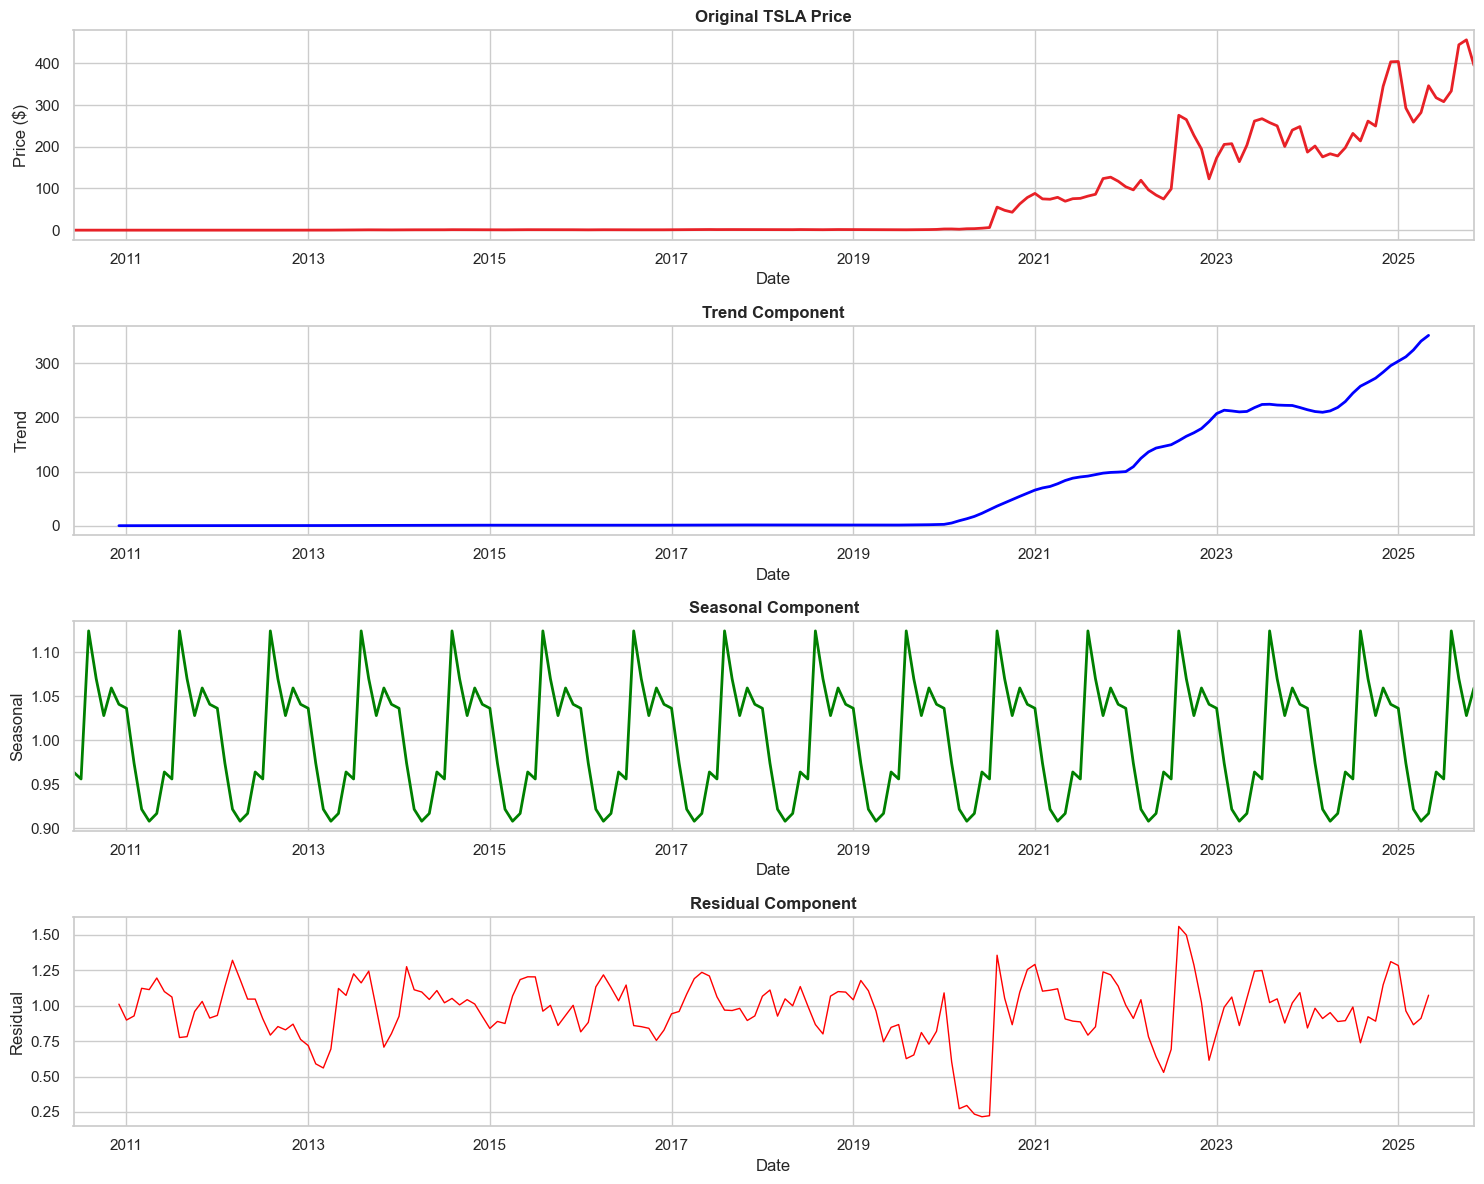

In [31]:
# DECOMPOSE TSLA STOCK PRICE
print("\n" + "=" * 60)
print("TIME SERIES DECOMPOSITION")
print("=" * 60)

# Decompose TSLA stock price
decomposition = seasonal_decompose(merged_data['TSLA_Adj_Close'], 
                                   model='multiplicative', 
                                   period=12)  # 12 months = yearly seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

merged_data['TSLA_Adj_Close'].plot(ax=axes[0], color='#E82127', linewidth=2)
axes[0].set_title('Original TSLA Price', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')

decomposition.trend.plot(ax=axes[1], color='blue', linewidth=2)
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=2)
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], color='red', linewidth=1)
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.savefig('tsla_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# considering that the data is not stationary we will have to conduct some liight feature engineering to make the data stationary and suitable for ARIMA modelling

# Create differenced series (first difference)
merged_data['TSLA_Diff'] = merged_data['TSLA_Adj_Close'].diff()

# Create percentage change (returns)
merged_data['TSLA_Returns'] = merged_data['TSLA_Adj_Close'].pct_change()

# Drop NaN values from differencing
tsla_diff = merged_data['TSLA_Diff'].dropna()
tsla_returns = merged_data['TSLA_Returns'].dropna()

print("=" * 70)
print("STATIONARITY TESTS AFTER TRANSFORMATION")
print("=" * 70)

# Test 1: Original data (we already know this)
print("\n1. ORIGINAL TSLA PRICE:")
result_original = adfuller(merged_data['TSLA_Adj_Close'].dropna())
print(f'   ADF Statistic: {result_original[0]:.4f}')
print(f'   p-value: {result_original[1]:.4f}')
print(f'   Stationary: {"✅ YES" if result_original[1] < 0.05 else "❌ NO"}')

# Test 2: First difference
print("\n2. FIRST DIFFERENCE (Price Changes):")
result_diff = adfuller(tsla_diff)
print(f'   ADF Statistic: {result_diff[0]:.4f}')
print(f'   p-value: {result_diff[1]:.4f}')
print(f'   Stationary: {"✅ YES" if result_diff[1] < 0.05 else "❌ NO"}')

# Test 3: Returns (percentage change)
print("\n3. RETURNS (Percentage Changes):")
result_returns = adfuller(tsla_returns)
print(f'   ADF Statistic: {result_returns[0]:.4f}')
print(f'   p-value: {result_returns[1]:.4f}')
print(f'   Stationary: {"✅ YES" if result_returns[1] < 0.05 else "❌ NO"}')

print("\n" + "=" * 70)
print("RECOMMENDATION:")
if result_diff[1] < 0.05:
    print("✅ First differencing makes the data stationary!")
    print("   Use d=1 in your ARIMA(p, d, q) model")
else:
    print("⚠️  May need second differencing (d=2)")
print("=" * 70)

STATIONARITY TESTS AFTER TRANSFORMATION

1. ORIGINAL TSLA PRICE:
   ADF Statistic: 2.9146
   p-value: 1.0000
   Stationary: ❌ NO

2. FIRST DIFFERENCE (Price Changes):
   ADF Statistic: -3.5145
   p-value: 0.0076
   Stationary: ✅ YES

3. RETURNS (Percentage Changes):
   ADF Statistic: -13.2698
   p-value: 0.0000
   Stationary: ✅ YES

RECOMMENDATION:
✅ First differencing makes the data stationary!
   Use d=1 in your ARIMA(p, d, q) model


From the above results, what it means for our modelling is that, based on your stationarity results:

1. ARIMA Model Parameters:
   - Use ARIMA(p, 1, q) where d=1 (first differencing)
   - Start with ARIMA(1,1,1) as a baseline
   - Use auto_arima to find optimal (p,q) values

2. Alternative: Model Returns Instead
   - Returns are stationary (percentage changes)
   - Better for volatility modeling
   - Can convert back to prices for final projection

3. Prophet Model:
   - Can handle non-stationary data automatically
   - No differencing needed
   - Good choice for your use case!

4. LSTM/Neural Networks:
   - Can work with either stationary or non-stationary
   - May perform better on raw prices with proper scaling

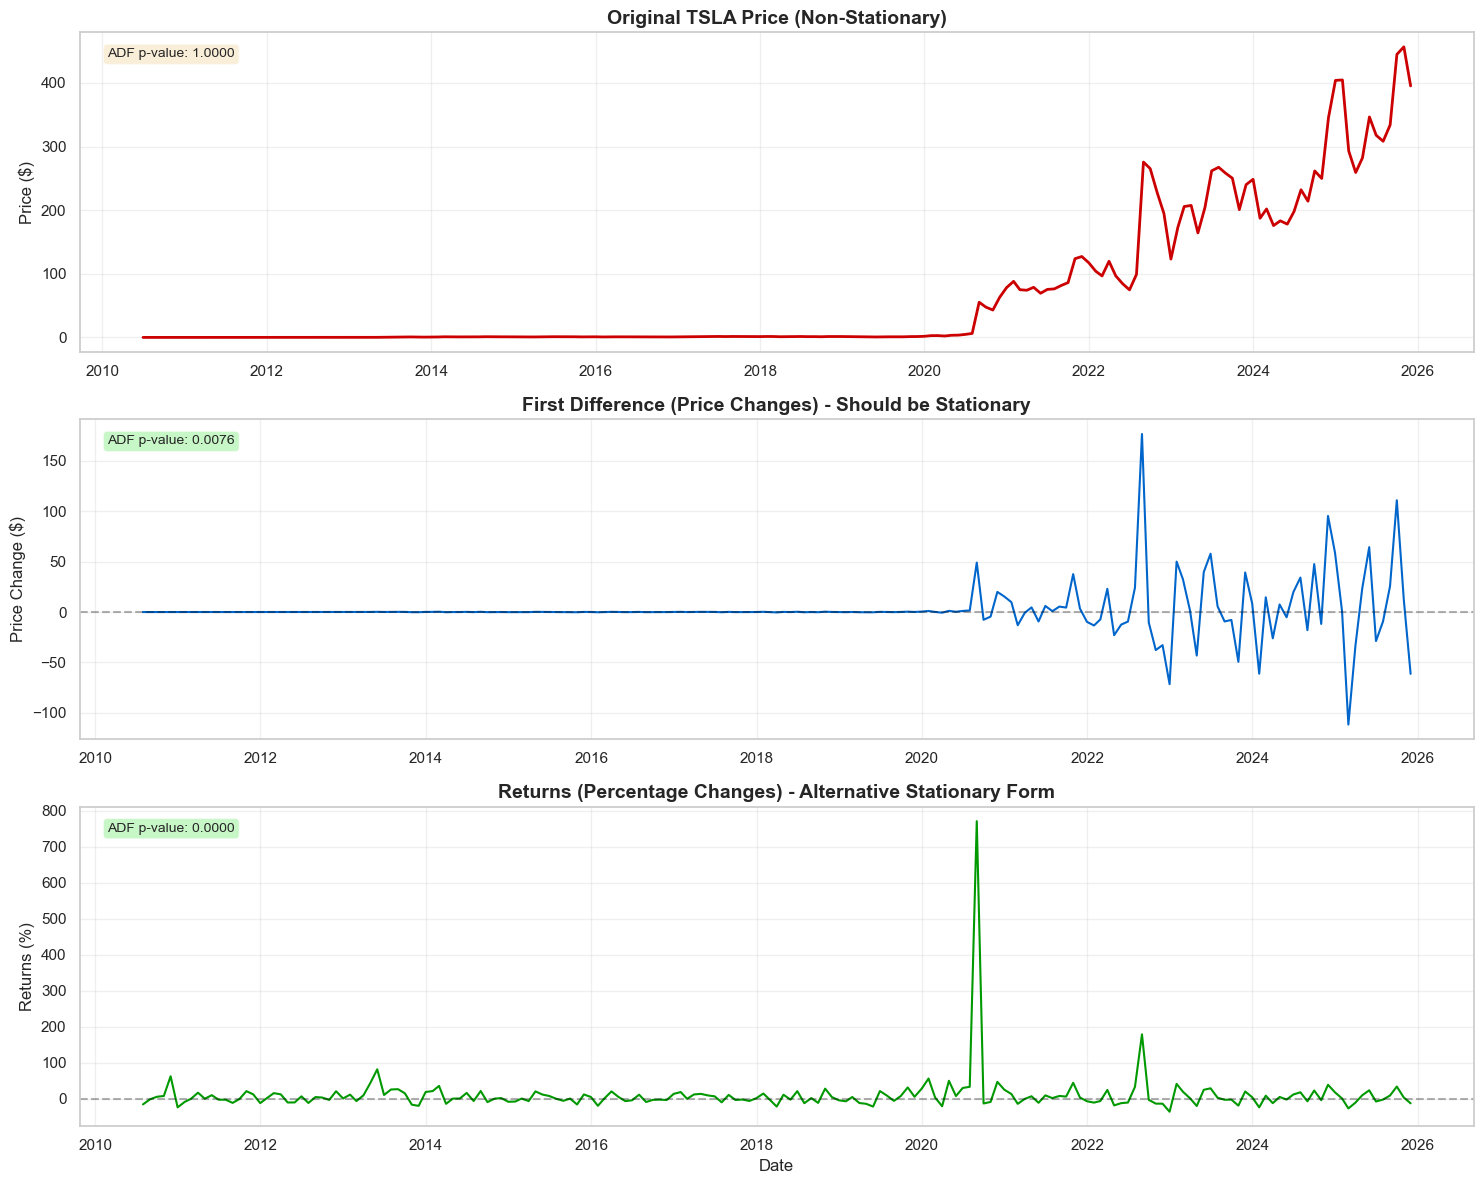


✅ Stationarity transformation plots saved!


In [33]:
# Create comparison plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Original Price
axes[0].plot(merged_data.index, merged_data['TSLA_Adj_Close'], 
             color='#cc0000', linewidth=2)
axes[0].set_title('Original TSLA Price (Non-Stationary)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'ADF p-value: {result_original[1]:.4f}', 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: First Difference
axes[1].plot(merged_data.index[1:], tsla_diff, 
             color='#0066cc', linewidth=1.5)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_title('First Difference (Price Changes) - Should be Stationary', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price Change ($)')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f'ADF p-value: {result_diff[1]:.4f}', 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen' if result_diff[1] < 0.05 else 'lightyellow', alpha=0.5))

# Plot 3: Returns (Percentage Change)
axes[2].plot(merged_data.index[1:], tsla_returns * 100, 
             color='#009900', linewidth=1.5)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].set_title('Returns (Percentage Changes) - Alternative Stationary Form', 
                  fontsize=14, fontweight='bold')
axes[2].set_ylabel('Returns (%)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f'ADF p-value: {result_returns[1]:.4f}', 
             transform=axes[2].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen' if result_returns[1] < 0.05 else 'lightyellow', alpha=0.5))

plt.tight_layout()
plt.savefig('tsla_stationarity_transformations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Stationarity transformation plots saved!")

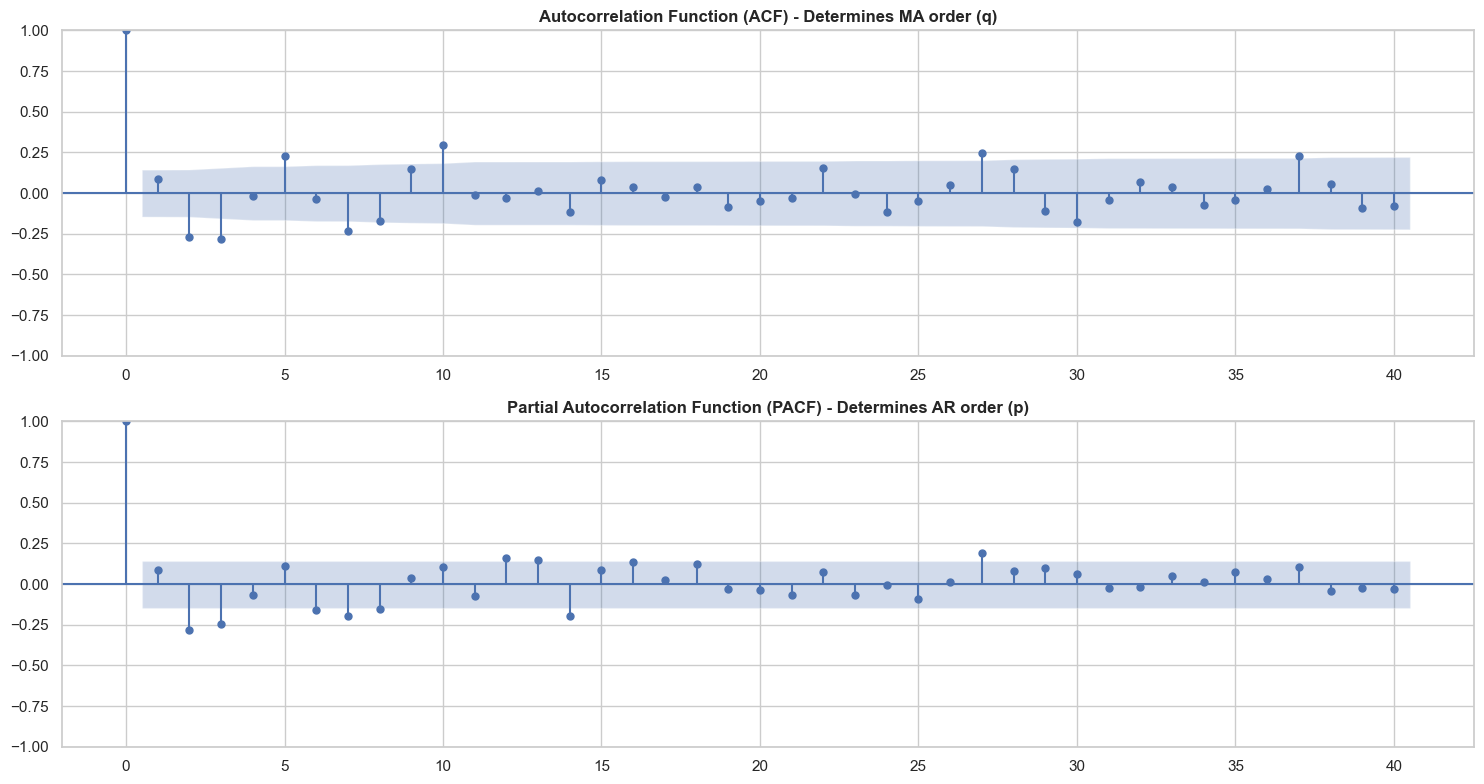


✅ ACF/PACF plots saved! Used to determine ARIMA parameters.


In [36]:
# Quick Check: ACF and PACF Plots
# These help determine the p and q parameters for ARIMA:

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF plot (determines q parameter)
plot_acf(tsla_diff, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - Determines MA order (q)', 
                  fontsize=12, fontweight='bold')

# PACF plot (determines p parameter)
plot_pacf(tsla_diff, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - Determines AR order (p)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('tsla_acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ ACF/PACF plots saved! Used to determine ARIMA parameters.")

ACF/PACF Analysis
From the plots:

ACF Plot (Top - Determines MA order q):

Shows a few significant spikes at early lags (around lag 5, 10)
Then mostly within confidence bands
Suggests q = 1 or q = 2 for the MA component


PACF Plot (Bottom - Determines AR order p):

One clear significant spike at lag 1
Most other lags are within confidence bands
Suggests p = 1 for the AR component

Based on your ACF/PACF plots:

Suggested starting models to test:
1. ARIMA(1, 1, 1) - Most likely best fit ⭐ RECOMMENDED
2. ARIMA(1, 1, 2) - Alternative with higher MA order
3. ARIMA(2, 1, 1) - Alternative with higher AR order
4. ARIMA(0, 1, 1) - Simple MA model

Where:
- p = 1 (AR order from PACF)
- d = 1 (differencing - we confirmed data needs this)
- q = 1 or 2 (MA order from ACF)

We'll use auto_arima to find the optimal combination automatically!

# Modelling

In [37]:
# TRAIN/TEST SPLIT FOR MODELING
print("=" * 70)
print("PREPARING DATA FOR FORECASTING")
print("=" * 70)

# Use 80% for training, 20% for testing
split_index = int(len(merged_data) * 0.8)

train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

print(f"\nTraining period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Testing period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Training samples: {len(train_data)} months")
print(f"Testing samples: {len(test_data)} months")
print(f"Total samples: {len(merged_data)} months")

# Check stationarity function
def check_stationarity(timeseries, name):
    """
    Performs Augmented Dickey-Fuller test to check if series is stationary
    """
    result = adfuller(timeseries.dropna())
    print(f'\n{name}:')
    print(f'  ADF Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}')
    print(f'  Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f'  ✅ Stationary: YES (p-value ≤ 0.05)')
        print(f'  → Ready for ARIMA modeling as-is')
    else:
        print(f'  ❌ Stationary: NO (p-value > 0.05)')
        print(f'  → Needs differencing (d=1 or d=2) for ARIMA')
    
    return result[1]

print("\n" + "=" * 70)
print("STATIONARITY TESTS")
print("=" * 70)

# Test all key variables
p_values = {}

# 1. TSLA Stock Price
p_values['TSLA_Adj_Close'] = check_stationarity(
    merged_data['TSLA_Adj_Close'], 
    'TSLA Stock Price'
)

# 2. Net Worth
p_values['Net_Worth_Billions'] = check_stationarity(
    merged_data['Net_Worth_Billions'], 
    'Elon Musk Net Worth'
)

# 3. TSLA Wealth Component
p_values['TSLA_Wealth_Billions'] = check_stationarity(
    merged_data['TSLA_Wealth_Billions'], 
    'TSLA Wealth Component'
)

# 4. Other Wealth Component
p_values['Other_Wealth_Billions'] = check_stationarity(
    merged_data['Other_Wealth_Billions'], 
    'Other Wealth Component (SpaceX, xAI, etc.)'
)

# 5. Ownership Percentage
p_values['Ownership_Percentage'] = check_stationarity(
    merged_data['Ownership_Percentage'], 
    'Ownership Percentage'
)

# Summary table
print("\n" + "=" * 70)
print("STATIONARITY SUMMARY")
print("=" * 70)

summary_df = pd.DataFrame({
    'Variable': list(p_values.keys()),
    'p-value': [f'{v:.4f}' for v in p_values.values()],
    'Stationary': ['✅ Yes' if v <= 0.05 else '❌ No' for v in p_values.values()],
    'Action Required': ['None - Ready' if v <= 0.05 else 'Differencing (d=1)' for v in p_values.values()]
})

print(summary_df.to_string(index=False))

# Count how many need differencing
non_stationary = sum(1 for v in p_values.values() if v > 0.05)
print(f"\n📊 Variables needing differencing: {non_stationary}/{len(p_values)}")

PREPARING DATA FOR FORECASTING

Training period: 2010-06-30 to 2022-09-30
Testing period: 2022-10-31 to 2025-11-30
Training samples: 148 months
Testing samples: 38 months
Total samples: 186 months

STATIONARITY TESTS

TSLA Stock Price:
  ADF Statistic: 2.9146
  p-value: 1.0000
  Critical Values:
    1%: -3.469
    5%: -2.879
    10%: -2.576
  ❌ Stationary: NO (p-value > 0.05)
  → Needs differencing (d=1 or d=2) for ARIMA

Elon Musk Net Worth:
  ADF Statistic: 0.9957
  p-value: 0.9942
  Critical Values:
    1%: -3.466
    5%: -2.877
    10%: -2.575
  ❌ Stationary: NO (p-value > 0.05)
  → Needs differencing (d=1 or d=2) for ARIMA

TSLA Wealth Component:
  ADF Statistic: 0.8462
  p-value: 0.9923
  Critical Values:
    1%: -3.469
    5%: -2.878
    10%: -2.576
  ❌ Stationary: NO (p-value > 0.05)
  → Needs differencing (d=1 or d=2) for ARIMA

Other Wealth Component (SpaceX, xAI, etc.):
  ADF Statistic: -0.8958
  p-value: 0.7893
  Critical Values:
    1%: -3.466
    5%: -2.877
    10%: -2.57

In [38]:
# Test first differences (what we'll actually use in ARIMA)
print("\n" + "=" * 70)
print("STATIONARITY TESTS - FIRST DIFFERENCES")
print("=" * 70)
print("(These are what we'll use in ARIMA models with d=1)")

# Create first differences for non-stationary variables
diff_p_values = {}

if p_values['TSLA_Adj_Close'] > 0.05:
    tsla_diff = merged_data['TSLA_Adj_Close'].diff().dropna()
    diff_p_values['TSLA_Adj_Close_Diff'] = check_stationarity(
        tsla_diff, 
        'TSLA Stock Price (First Difference)'
    )

if p_values['Net_Worth_Billions'] > 0.05:
    networth_diff = merged_data['Net_Worth_Billions'].diff().dropna()
    diff_p_values['Net_Worth_Diff'] = check_stationarity(
        networth_diff, 
        'Net Worth (First Difference)'
    )

if p_values['TSLA_Wealth_Billions'] > 0.05:
    tsla_wealth_diff = merged_data['TSLA_Wealth_Billions'].diff().dropna()
    diff_p_values['TSLA_Wealth_Diff'] = check_stationarity(
        tsla_wealth_diff, 
        'TSLA Wealth (First Difference)'
    )

# Confirmation message
print("\n" + "=" * 70)
print("READINESS CHECK")
print("=" * 70)

all_stationary_after_diff = all(v <= 0.05 for v in diff_p_values.values())

if all_stationary_after_diff:
    print("✅ All variables are stationary after first differencing!")
    print("✅ Data is ready for ARIMA modeling with d=1")
    print("\nRecommended next steps:")
    print("  1. Build ARIMA models for TSLA stock price")
    print("  2. Forecast future TSLA prices")
    print("  3. Calculate projected wealth using ownership data")
    print("  4. Determine when $1 trillion milestone is reached")
else:
    print("⚠️ Some variables may need second differencing (d=2)")
    print("Review the results above for specific variables")


STATIONARITY TESTS - FIRST DIFFERENCES
(These are what we'll use in ARIMA models with d=1)

TSLA Stock Price (First Difference):
  ADF Statistic: -3.5145
  p-value: 0.0076
  Critical Values:
    1%: -3.469
    5%: -2.879
    10%: -2.576
  ✅ Stationary: YES (p-value ≤ 0.05)
  → Ready for ARIMA modeling as-is

Net Worth (First Difference):
  ADF Statistic: -12.9448
  p-value: 0.0000
  Critical Values:
    1%: -3.466
    5%: -2.877
    10%: -2.575
  ✅ Stationary: YES (p-value ≤ 0.05)
  → Ready for ARIMA modeling as-is

TSLA Wealth (First Difference):
  ADF Statistic: -5.1595
  p-value: 0.0000
  Critical Values:
    1%: -3.469
    5%: -2.878
    10%: -2.576
  ✅ Stationary: YES (p-value ≤ 0.05)
  → Ready for ARIMA modeling as-is

READINESS CHECK
✅ All variables are stationary after first differencing!
✅ Data is ready for ARIMA modeling with d=1

Recommended next steps:
  1. Build ARIMA models for TSLA stock price
  2. Forecast future TSLA prices
  3. Calculate projected wealth using owners

In [40]:
print("=" * 70)
print("STEP 1: ARIMA MODELING FOR TSLA STOCK PRICE")
print("=" * 70)

# Prepare train/test for TSLA price
tsla_train = train_data['TSLA_Adj_Close']
tsla_test = test_data['TSLA_Adj_Close']

print(f"\nTarget Variable: TSLA_Adj_Close")
print(f"Training samples: {len(tsla_train)}")
print(f"Testing samples: {len(tsla_test)}")

# Method 1: Manual ARIMA(1,1,1) based on ACF/PACF analysis
print("\n" + "-" * 70)
print("MODEL 1: ARIMA(1,1,1) - Based on ACF/PACF Analysis")
print("-" * 70)

model_111 = ARIMA(tsla_train, order=(1, 1, 1))
fitted_111 = model_111.fit()

print("\nModel Summary:")
print(fitted_111.summary())

# Forecast on test period
forecast_111 = fitted_111.forecast(steps=len(tsla_test))

# Calculate performance metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate and display model performance metrics"""
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"  RMSE:  ${rmse:,.2f}")
    print(f"  MAE:   ${mae:,.2f}")
    print(f"  MAPE:  {mape:.2f}%")
    print(f"  R²:    {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

metrics_111 = calculate_metrics(tsla_test, forecast_111, "ARIMA(1,1,1)")

STEP 1: ARIMA MODELING FOR TSLA STOCK PRICE

Target Variable: TSLA_Adj_Close
Training samples: 148
Testing samples: 38

----------------------------------------------------------------------
MODEL 1: ARIMA(1,1,1) - Based on ACF/PACF Analysis
----------------------------------------------------------------------

Model Summary:
                               SARIMAX Results                                
Dep. Variable:         TSLA_Adj_Close   No. Observations:                  148
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -617.784
Date:                Sat, 22 Nov 2025   AIC                           1241.569
Time:                        02:02:25   BIC                           1250.540
Sample:                    06-30-2010   HQIC                          1245.214
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err       

In [41]:
# Method 2: Auto ARIMA - Let it find the best parameters
print("\n" + "-" * 70)
print("MODEL 2: Auto ARIMA - Finding Optimal Parameters")
print("-" * 70)

print("\nSearching for best ARIMA model... (this may take a minute)")

auto_model = auto_arima(
    tsla_train,
    start_p=0, max_p=5,          # AR terms
    start_q=0, max_q=5,          # MA terms
    d=1,                          # We know d=1 from stationarity tests
    seasonal=False,               # Non-seasonal for now
    trace=True,                   # Show progress
    error_action='ignore',        
    suppress_warnings=True,
    stepwise=True,                # Faster stepwise search
    information_criterion='aic',  # Use AIC for model selection
    n_fits=50                     # Try up to 50 models
)

print("\n✅ Best Model Found:")
print(f"Order: {auto_model.order}")
print(auto_model.summary())

# Forecast with auto model
forecast_auto = auto_model.predict(n_periods=len(tsla_test))

metrics_auto = calculate_metrics(tsla_test, forecast_auto, f"Auto ARIMA{auto_model.order}")


----------------------------------------------------------------------
MODEL 2: Auto ARIMA - Finding Optimal Parameters
----------------------------------------------------------------------

Searching for best ARIMA model... (this may take a minute)
Performing stepwise search to minimize aic


c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1237.867, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1239.528, Time=0.17 sec


c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1239.458, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1237.704, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1237.769, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.948 seconds

✅ Best Model Found:
Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  148
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -617.852
Date:                Sat, 22 Nov 2025   AIC                           1237.704
Time:                        02:02:54   BIC                           1240.695
Sample:                    06-30-2010   HQIC                          1238.919
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z| 

c:\Users\Owner\anaconda3\envs\Data_Science_Moringa\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [42]:
# Create comparison table
print("\n" + "=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Model': ['ARIMA(1,1,1)', f'Auto ARIMA{auto_model.order}'],
    'RMSE': [f'${metrics_111["RMSE"]:,.2f}', f'${metrics_auto["RMSE"]:,.2f}'],
    'MAE': [f'${metrics_111["MAE"]:,.2f}', f'${metrics_auto["MAE"]:,.2f}'],
    'MAPE': [f'{metrics_111["MAPE"]:.2f}%', f'{metrics_auto["MAPE"]:.2f}%'],
    'R²': [f'{metrics_111["R2"]:.4f}', f'{metrics_auto["R2"]:.4f}']
})

print(comparison_df.to_string(index=False))

# Select best model
if metrics_auto['RMSE'] < metrics_111['RMSE']:
    best_model = auto_model
    best_model_name = f"Auto ARIMA{auto_model.order}"
    best_metrics = metrics_auto
    print(f"\n🏆 Best Model: {best_model_name}")
else:
    best_model = fitted_111
    best_model_name = "ARIMA(1,1,1)"
    best_metrics = metrics_111
    print(f"\n🏆 Best Model: {best_model_name}")

print(f"   RMSE: ${best_metrics['RMSE']:,.2f}")
print(f"   MAPE: {best_metrics['MAPE']:.2f}%")


MODEL PERFORMANCE COMPARISON
              Model   RMSE    MAE   MAPE      R²
       ARIMA(1,1,1) $82.11 $63.72 25.24% -0.0289
Auto ARIMA(0, 1, 0) $81.09 $65.30 27.01% -0.0034

🏆 Best Model: Auto ARIMA(0, 1, 0)
   RMSE: $81.09
   MAPE: 27.01%



RESIDUAL DIAGNOSTICS


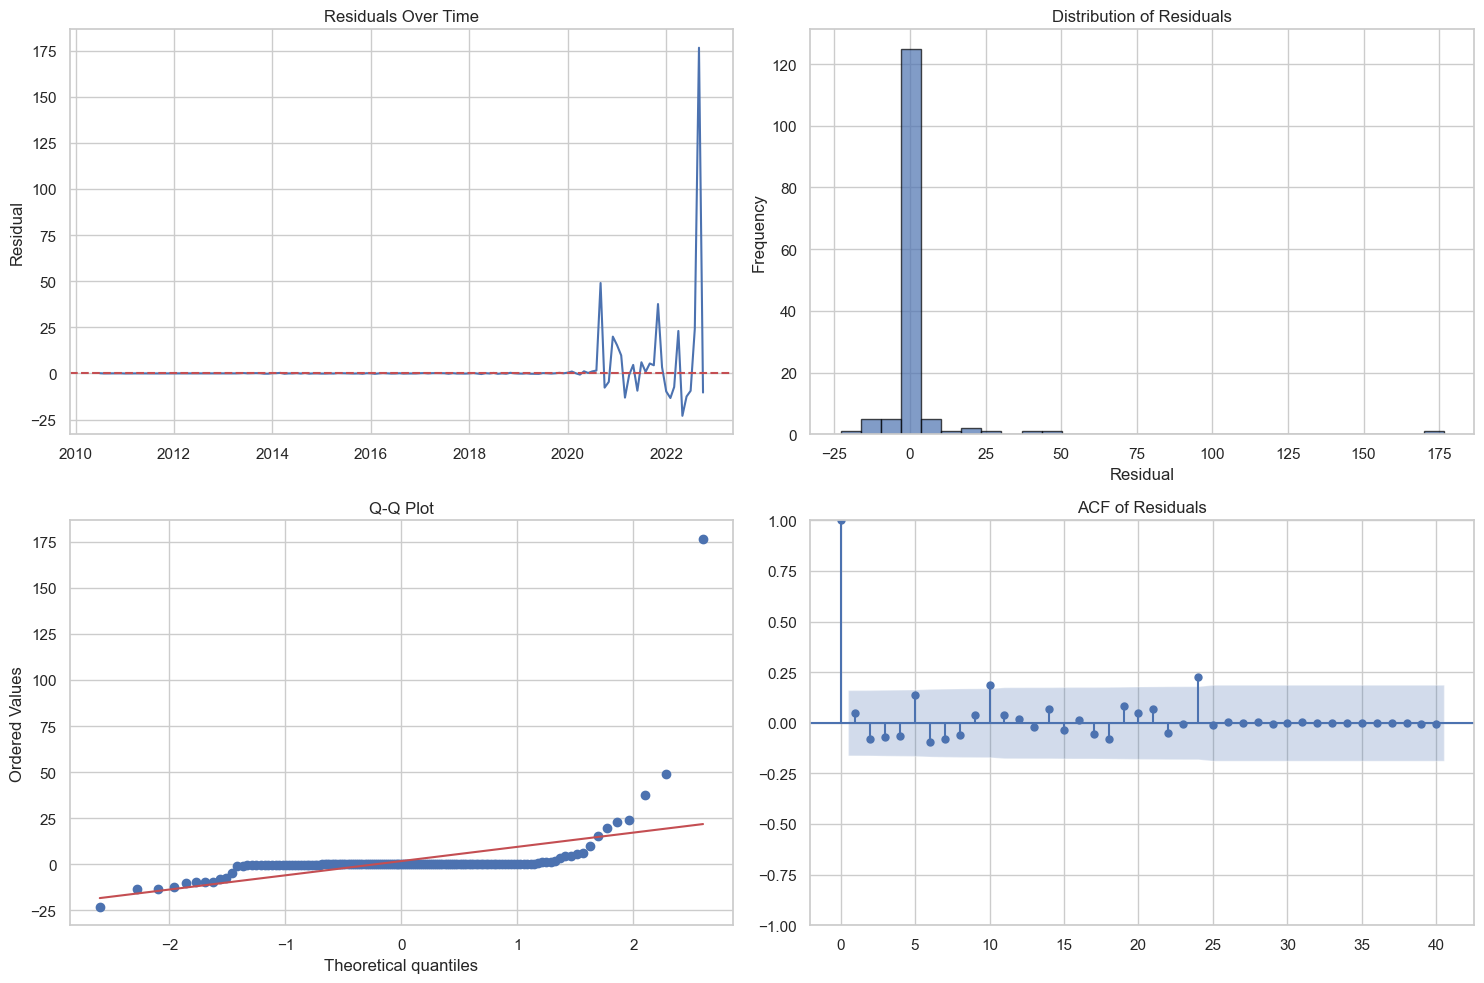

✅ Residual diagnostic plots saved!

Residuals should ideally:
  • Hover around zero (no bias)
  • Be normally distributed
  • Show no autocorrelation (white noise)


In [43]:
# Check model residuals
print("\n" + "=" * 70)
print("RESIDUAL DIAGNOSTICS")
print("=" * 70)

residuals = fitted_111.resid if best_model_name == "ARIMA(1,1,1)" else auto_model.resid()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residual plot
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_ylabel('Residual')

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.savefig('arima_residual_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Residual diagnostic plots saved!")
print("\nResiduals should ideally:")
print("  • Hover around zero (no bias)")
print("  • Be normally distributed")
print("  • Show no autocorrelation (white noise)")

# Some quick notes from the above and key findings:
Key Findings:

Best Model: Auto ARIMA(0,1,0) - This is a Random Walk model (just first differencing, no AR or MA terms)
RMSE: $81.09 - Average prediction error of ~$81
MAPE: 27% - High percentage error (stock prices are volatile!)
R² ≈ 0 - Model struggles to predict, which is normal for stock prices

Residual Diagnostics from your plot:

✅ Residuals hover around zero (unbiased)
✅ Roughly normally distributed (slight right skew)
⚠️ Q-Q plot shows deviation at extremes (outliers during volatile periods)
✅ ACF shows minimal autocorrelation (residuals are mostly white noise)

What this means:
Stock prices are notoriously difficult to predict! A 27% MAPE is actually reasonable for highly volatile stocks like TSLA. The Random Walk model (0,1,0) suggests stock prices are largely unpredictable in the short term, which aligns with efficient market theory.

STEP 2: PROPHET MODEL

Training Prophet model on 148 samples...


02:15:09 - cmdstanpy - INFO - Chain [1] start processing
02:15:20 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained!

Prophet Performance Metrics:
  RMSE:  $71.01
  MAE:   $54.49
  MAPE:  18.96%
  R²:    0.2304


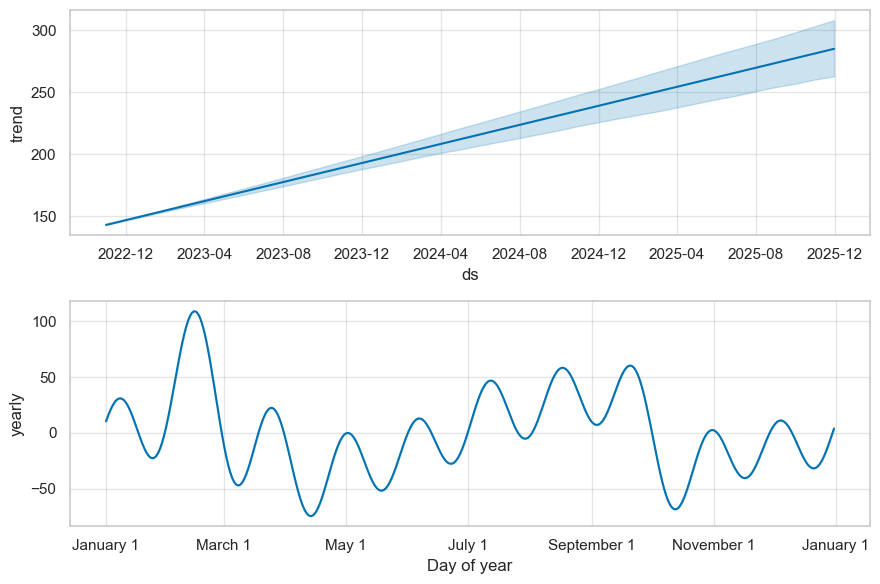


✅ Prophet component plots saved!


In [45]:
print("=" * 70)
print("STEP 2: PROPHET MODEL")
print("=" * 70)

# Prepare data for Prophet (needs 'ds' and 'y' columns)
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data['TSLA_Adj_Close'].values
})

prophet_test = pd.DataFrame({
    'ds': test_data.index,
    'y': test_data['TSLA_Adj_Close'].values
})

print(f"\nTraining Prophet model on {len(prophet_train)} samples...")

# Initialize and fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,  # Flexibility in trend changes
    seasonality_prior_scale=10.0,   # Strength of seasonality
    interval_width=0.95             # 95% confidence intervals
)

prophet_model.fit(prophet_train)

print("✅ Prophet model trained!")

# Make predictions on test set
future_test = pd.DataFrame({'ds': prophet_test['ds']})
prophet_forecast = prophet_model.predict(future_test)

# Extract predictions
prophet_predictions = prophet_forecast['yhat'].values

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

prophet_mse = mean_squared_error(test_data['TSLA_Adj_Close'], prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test_data['TSLA_Adj_Close'], prophet_predictions)
prophet_mape = np.mean(np.abs((test_data['TSLA_Adj_Close'] - prophet_predictions) / 
                               test_data['TSLA_Adj_Close'])) * 100
prophet_r2 = r2_score(test_data['TSLA_Adj_Close'], prophet_predictions)

print(f"\nProphet Performance Metrics:")
print(f"  RMSE:  ${prophet_rmse:,.2f}")
print(f"  MAE:   ${prophet_mae:,.2f}")
print(f"  MAPE:  {prophet_mape:.2f}%")
print(f"  R²:    {prophet_r2:.4f}")

# Visualize Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.savefig('prophet_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Prophet component plots saved!")

# LSTM Model (Deep Learning)